# In this project I am going to classify fake posts on subreddit from r/TheOnion and r/nottheonion

In [1]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)


Mounted at gdrive


In [0]:
# Basic libraries
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix



In [0]:
# r/TheOnion DataFrame
df_onion = pd.read_csv('gdrive/My Drive/data/the_onion.csv')

# r/nottheonion DataFrame
df_not_onion = pd.read_csv('gdrive/My Drive/data/not_onion.csv')


In [4]:
# Show first 3 rows of df_onion
print("Shape:", df_onion.shape)
df_onion.head(3)

Shape: (14868, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,Kotaay,google.ca,1,1,TheOnion,1554658622,Jack Nicholson Banned From Sitting Courtside A...
1,1,DisastrousCandy3,theonion.com,3,1,TheOnion,1554600149,NicoDerm Introduces New Nicotine Eye Patch
2,2,SlovenianCat,youtu.be,0,1,TheOnion,1554585700,Last Bastion Of U.S. Economy Succumbs To Pancr...


In [5]:
# Show first 3 rows of df_not_onion
print("Shape:", df_not_onion.shape)
df_not_onion.head(3)

Shape: (15000, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,drak0bsidian,cnn.com,0,1,nottheonion,1554663925,Suspected rhino poacher is killed by an elepha...
1,1,somefaces,nypost.com,1,1,nottheonion,1554663648,Taliban commander turns himself in to collect ...
2,2,Sombez,nytimes.com,1,1,nottheonion,1554663558,Rhino Poacher Killed by Elephant and Eaten by ...


In [0]:
# Decontracting the phrases
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')
    
    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')
    
    # Remove worrds with numbers
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z0-9]+',' ')
    
    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    
    # Decontraction
    dataframe['title']= dataframe.apply(lambda row: decontracted(row['title']),axis=1)
    
    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [8]:
clean_data(df_not_onion)

New shape: (12086, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,drak0bsidian,cnn.com,0,1,nottheonion,1554663925,suspected rhino poacher is killed by an elepha...
1,1,somefaces,nypost.com,1,1,nottheonion,1554663648,taliban commander turns himself in to collect ...
2,2,Sombez,nytimes.com,1,1,nottheonion,1554663558,rhino poacher killed by elephant and eaten by ...
3,3,Bayou-Maharaja,ktoo.org,0,1,nottheonion,1554662778,young shoves female reporter on way to violenc...
4,4,phantommaster1999,buzz.ie,1,1,nottheonion,1554661988,poacher hunting rhinos trampled to death by el...


In [9]:
# Call `clean_data(dataframe)` function
clean_data(df_onion)

New shape: (14189, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,Kotaay,google.ca,1,1,TheOnion,1554658622,jack nicholson banned from sitting courtside a...
1,1,DisastrousCandy3,theonion.com,3,1,TheOnion,1554600149,nicoderm introduces new nicotine eye patch
2,2,SlovenianCat,youtu.be,0,1,TheOnion,1554585700,last bastion of u s economy succumbs to pancre...
3,3,MyNameIsGriffon,sports.theonion.com,0,386,TheOnion,1554559311,tom izzo calls spartans best team he s ever th...
4,4,MyNameIsGriffon,theonion.com,0,3,TheOnion,1554501708,house democrats formally request trump s tax r...


In [10]:
# Create a DataFrame to check nulls
pd.DataFrame([df_onion.isnull().sum(),df_not_onion.isnull().sum()], index=["TheOnion","notheonion"]).T

,TheOnion,notheonion
Unnamed: 0,0,0
author,0,0
domain,0,0
num_comments,0,0
score,0,0
subreddit,0,0
timestamp,0,0
title,0,0


In [11]:
# Convert Unix Timestamp to Datetime
df_onion['timestamp'] = pd.to_datetime(df_onion['timestamp'], unit='s')
df_not_onion['timestamp'] = pd.to_datetime(df_not_onion['timestamp'], unit='s')

# Show date-range of posts scraped from r/TheOnion and r/nottheonion
print("TheOnion start date:", df_onion['timestamp'].min())
print("TheOnion end date:", df_onion['timestamp'].max())
print("nottheonion start date:", df_not_onion['timestamp'].min())
print("nottheonion end date:", df_not_onion['timestamp'].max())

TheOnion start date: 2013-10-04 00:38:59
TheOnion end date: 2019-04-07 17:37:02
nottheonion start date: 2019-01-25 01:00:09
nottheonion end date: 2019-04-07 19:05:25


In [0]:
# Bar plot function
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

# r/TheOnion: Most Active Authors

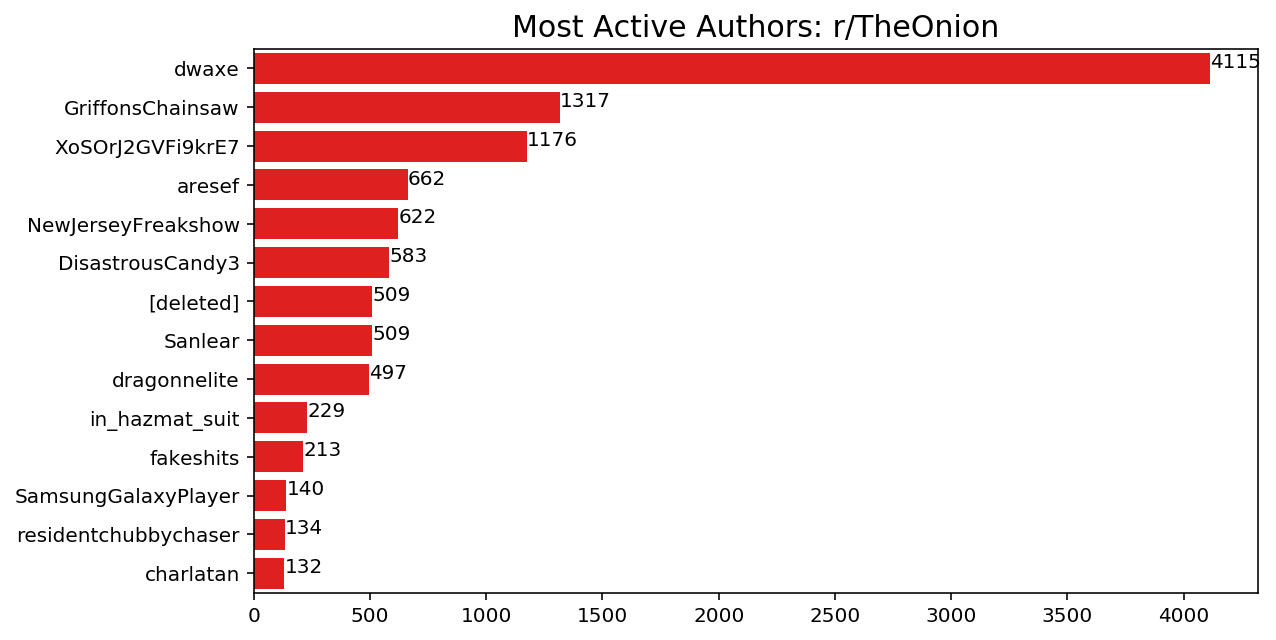

In [13]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values, df_onion_authors_index, 'Most Active Authors: r/TheOnion', 'r') 

###### r/The onion has 95k subscribers, but only 14 of them have more than 100 posts

### r/nottheonion: Most Active Authors

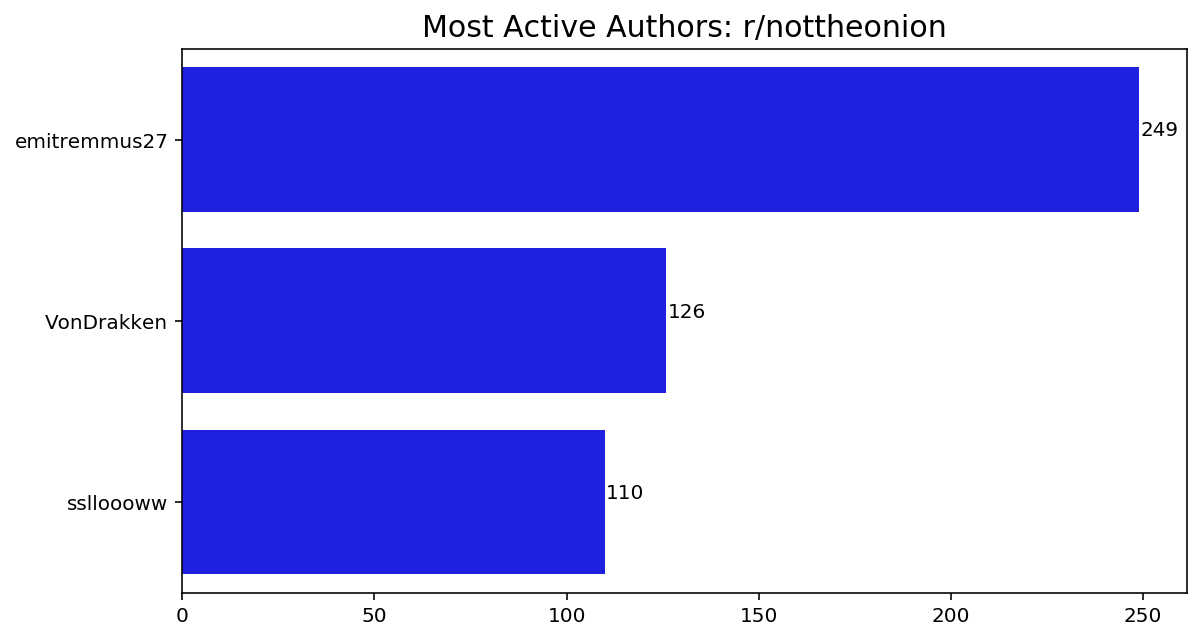

In [0]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts() 
df_not_onion_authors = df_not_onion_authors[df_not_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

# Call function
bar_plot(df_not_onion_authors.values, df_not_onion_authors_index, 'Most Active Authors: r/nottheonion','b') 

### r/the not onion 15million subscribers, but only 3 of them have more than 100 posts

### r/nottheonion: Most Referenced Domains

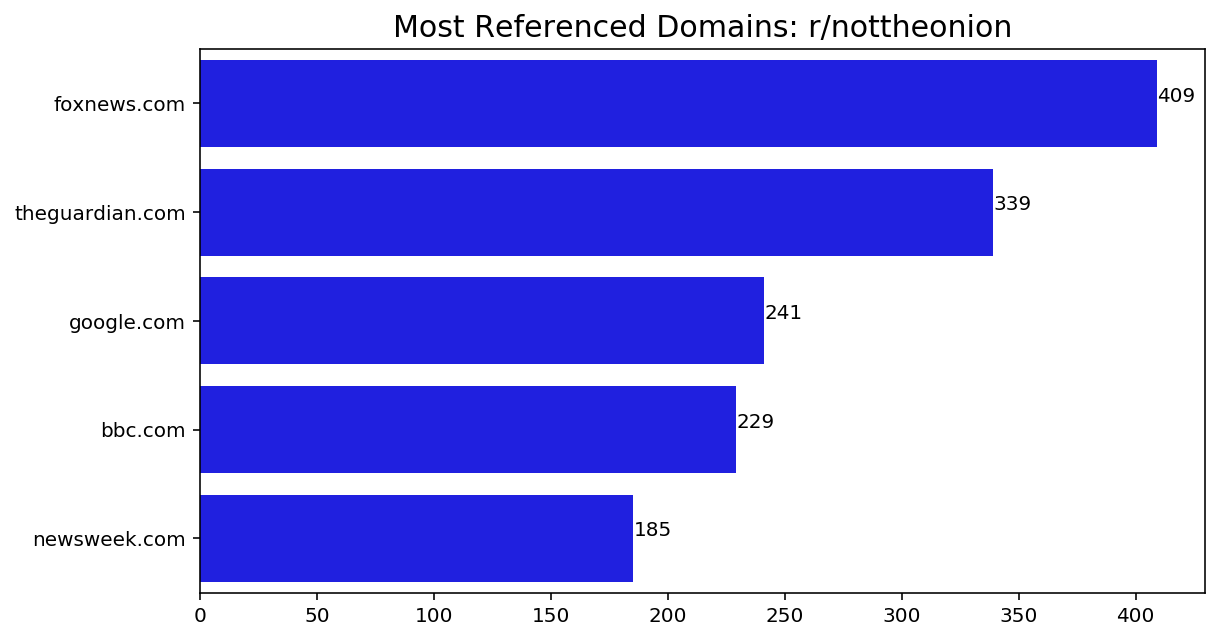

In [0]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','b') 

### Also unsurprisingly, foxnews.com is the most referenced domain in r/nottheonion! 

### r/theonion: Most Referenced Domains

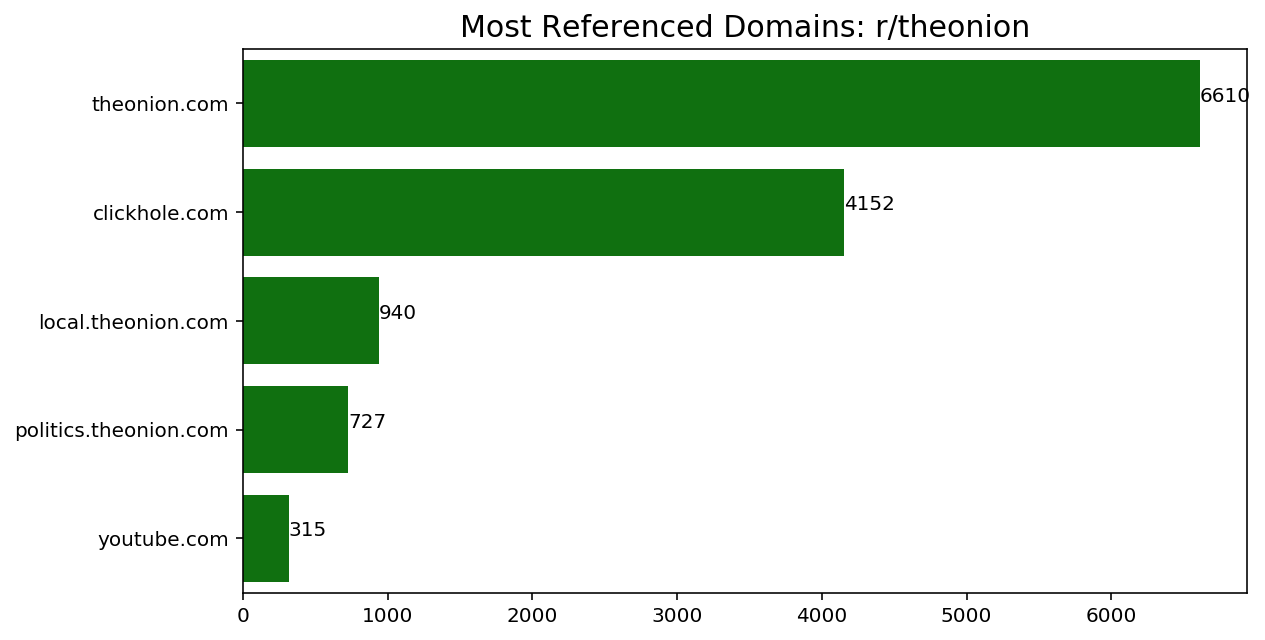

In [0]:
# Set x values: # of posts greater than 100
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_onion_domain_index = list(df_onion_domain.index)

# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/theonion','g') 

#### Also surprisingly, theonion.com is the most referenced domain in r/theonion! 

# Natural Language Processing (NLP)

In [14]:
# concatenate dataframes
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_not_onion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)

# Preview head of df to show 'TheOnion' titles appear
df.head(2)

,subreddit,title
0,TheOnion,jack nicholson banned from sitting courtside a...
1,TheOnion,nicoderm introduces new nicotine eye patch


In [0]:
# Preview head of df to show 'nottheonion' titles appear
df.tail(2)

,subreddit,title
26273,nottheonion,farming simulator starts up esports with k pri...
26274,nottheonion,mark zuckerberg killed goat with laser gun and...


### Binarize Target `subreddit`
 - `TheOnion`: 1
 - `nottheonion`: 0

In [15]:
# Replace `TheOnion` with 1, `nottheonion` with 0
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Print shape of df
print(df.shape)

# Preview head of df to show 1s
df.head(2)

(26275, 2)


,subreddit,title
0,1,jack nicholson banned from sitting courtside a...
1,1,nicoderm introduces new nicotine eye patch


In [0]:
# Preview tail of df to show 0s
df.tail(2)

,subreddit,title
26273,0,farming simulator starts up esports with k pri...
26274,0,mark zuckerberg killed goat with laser gun and...


## Apply `CountVectorizer()`

In [16]:
# Set variables to show TheOnion Titles
mask_on = df['subreddit'] == 1
df_onion_titles = df[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(analyzer='word',stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)
print(onion_cvec_df.head(3))

(14189, 11906)
   aaron  abandon  abandoned  abandoning  ...  zookeeper  zoologists  zuckerberg  zz
0      0        0          0           0  ...          0           0           0   0
1      0        0          0           0  ...          0           0           0   0
2      0        0          0           0  ...          0           0           0   0

[3 rows x 11906 columns]


### Count Vectorize `df` where `subreddit` is `0`
 - `ngram_range = (1,1)`

In [17]:
# Set variables to show NotTheOnion Titles
mask_no = df['subreddit'] == 0
df_not_onion_titles = df[mask_no]['title']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(12086, 14451)


### r/TheOnion: Top 5 Unigrams 

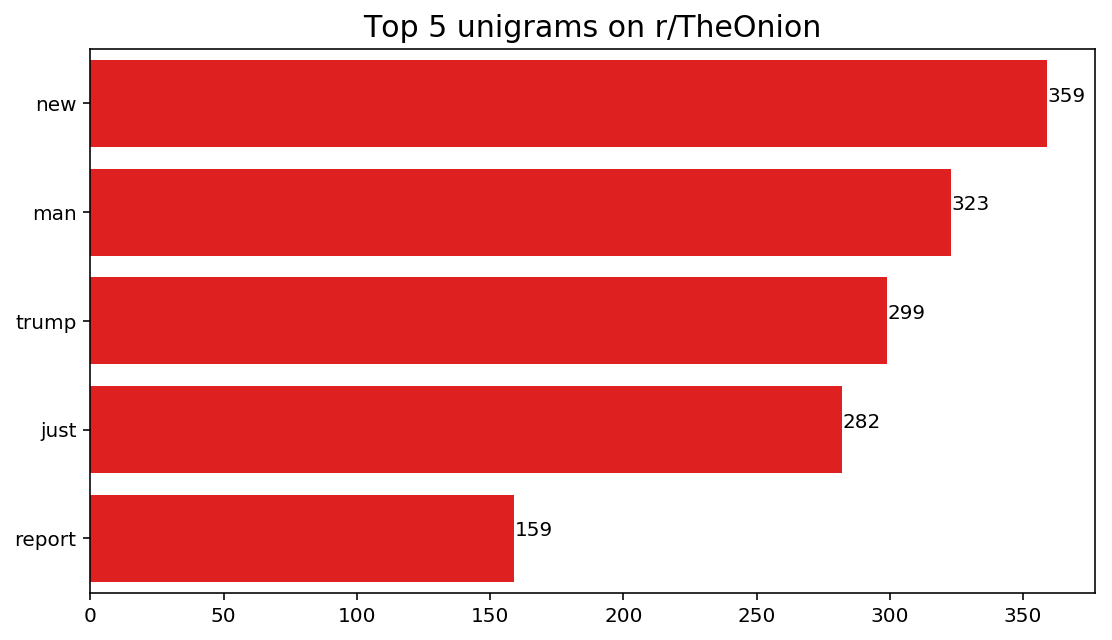

In [0]:
# Set up variables to contain top 5 most used words in Onion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 unigrams on r/TheOnion','r') 

### r/nottheonion: Top 5 Unigrams

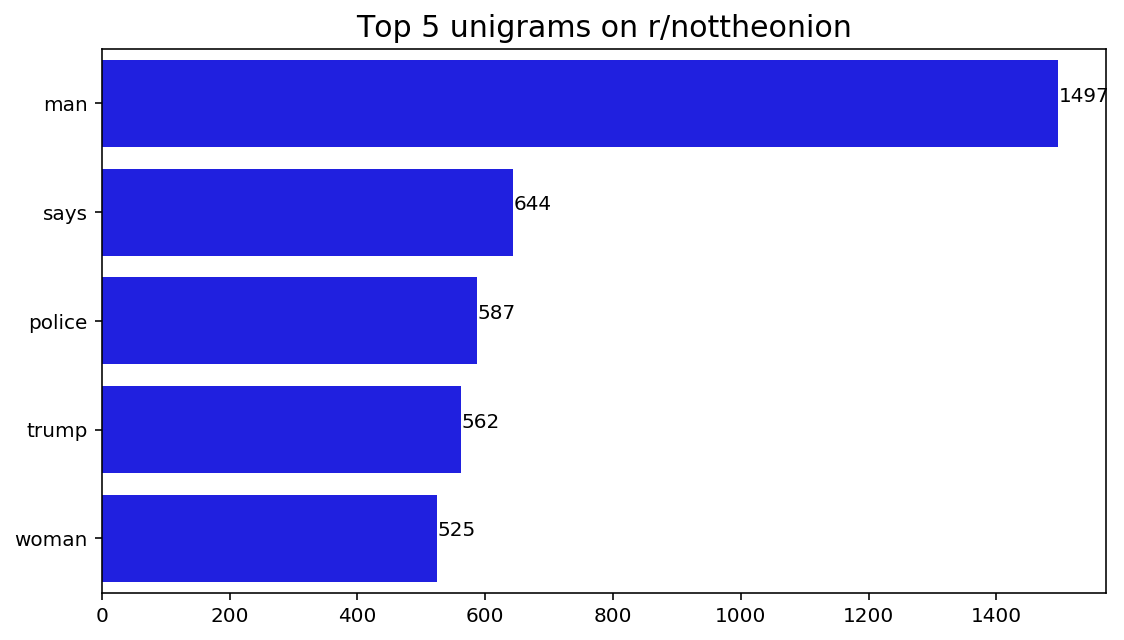

In [0]:
# Set up variables to contain top 5 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 unigrams on r/nottheonion','b') 

### Common unigrams between not_the_onion and the_onion

In [0]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'man', 'trump'}

### 'man' and 'trump' are the two top common words in unigram


### Set `X` (predictor) and `y` (target) variables 

In [0]:
X = df['title']
y = df['subreddit']

In [0]:
### Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

### Model 1: CountVectorizer & Logistic Regression (Best Coefficient Interpretability)

In [20]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8531411752765655
Train score 0.9618897797625089
Test score 0.8652762977622165


{'cvec__ngram_range': (1, 1), 'lr__C': 1}

### Model 2: TfidfVectorize & Logistic Regression

In [21]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8438546635542474
Train score 0.911651273723739
Test score 0.8558380270969707


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 3,
 'tvect__ngram_range': (1, 3)}

## Model 3,countvectorizer() and multinomial naive baiyes()

In [22]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8878514158124429
Train score 0.9970059880239521
Test score 0.8972446338864363


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.36}

# My best model is countvectorizer with multinomialNB() and accuracy 89.72%

In [23]:
# Best Models 
#Instantiate the classifier with best hyperparameter and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.8972446338864363


In [24]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2701,  321],
       [ 354, 3193]])

Text(0.5, 257.44, 'Predicted label')

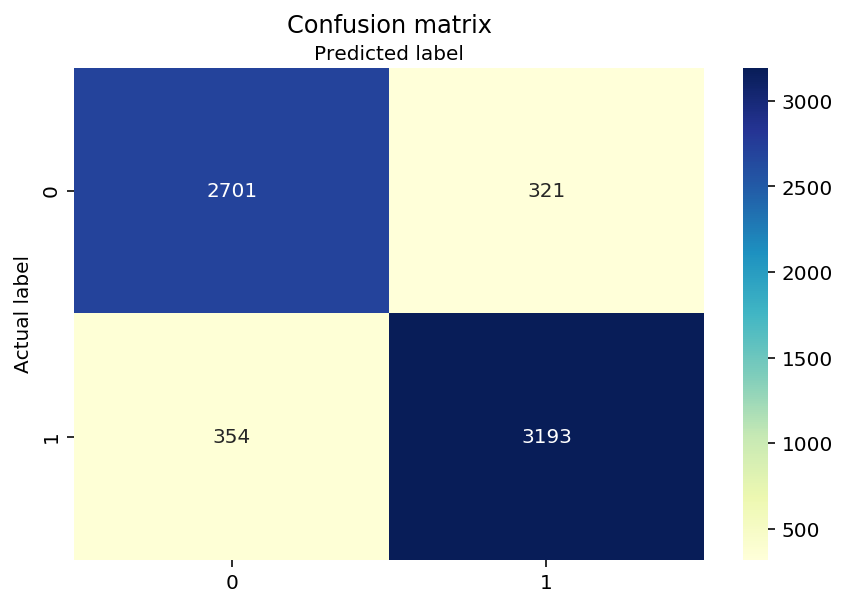

In [25]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [27]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 89.72 %
Precision: 90.87 %
Recall: 90.02 %
Specificity: 89.38 %
Misclassification Rate: 11.11 %


## The most model to optimize for accuracy in detecting fake news and absurd news uses CountVectorizer and MultinomialNB. The optimal parameters for this model are where `ngram_range` = (1,3) and `alpha` = 0.36. 
 - Accuracy: 89.72%
 - Precision: 90.87%
 - Recall: 90.02%
 - Specificity: 89.38%
 - Misclassification Rate: 11.11%

# <center> Sample Topic modeling

In [0]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [0]:
# spacy for lemmatization
import spacy
!pip install pyLDAvis

In [0]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(df['title']))

print(data_words[:1])

In [0]:
# Unigram and bigrams
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [0]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

In [0]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

### Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

### For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

### This is used as the input by the LDA model.

## Building LDA model

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [0]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# In topic 0, we find that word 'trump' is having weight 0.046 higher than other words weight in topic 0. So we can conclude that it is biased towards a person called 'TRUMP'
# In topic 1, we find that word 'arrest' is having weight 0.029 higher than other words weight in topic 1. So we can conclude that it is biased towards a crime or police in general


# <center> Sample Question Answer generation

In [0]:
from textblob import TextBlob
import nltk
from textblob import Word
import sys

In [0]:
verbose= True
def parse(string):
    """
    Parse a paragraph. Devide it into sentences and try to generate quesstions from each sentences.
    """
    
    try:
        txt = TextBlob(string)
        # Each sentence is taken from the string input and passed to genQuestion() to generate questions.
        for sentence in txt.sentences:
            genQuestion(sentence)

    except Exception as e:
        raise e



def genQuestion(line):
    """
    outputs question from the given text
    """
    

    if type(line) is str:     # If the passed variable is of type string.
        line = TextBlob(line) # Create object of type textblob.blob.TextBlob

    bucket = {}               # Create an empty dictionary


    for i,j in enumerate(line.tags):  # line.tags are the parts-of-speach in English
        if j[1] not in bucket:
            bucket[j[1]] = i  # Add all tags to the dictionary or bucket variable
    
    if verbose:               # In verbose more print the key,values of dictionary
        print('\n','-'*20)
        print(line ,'\n')        
        print("TAGS:",line.tags, '\n')  
        print(bucket)
    
    question = ''            # Create an empty string 

    # These are the english part-of-speach tags used in this demo program.
    #.....................................................................
    # NNS     Noun, plural
    # JJ  Adjective 
    # NNP     Proper noun, singular 
    # VBG     Verb, gerund or present participle 
    # VBN     Verb, past participle 
    # VBZ     Verb, 3rd person singular present 
    # VBD     Verb, past tense 
    # IN      Preposition or subordinating conjunction 
    # PRP     Personal pronoun 
    # NN  Noun, singular or mass 
    #.....................................................................

    # Create a list of tag-combination

    l1 = ['NNP', 'VBG', 'VBZ', 'IN']
    l2 = ['NNP', 'VBG', 'VBZ']
    

    l3 = ['PRP', 'VBG', 'VBZ', 'IN']
    l4 = ['PRP', 'VBG', 'VBZ']
    l5 = ['PRP', 'VBG', 'VBD']
    l6 = ['NNP', 'VBG', 'VBD']
    l7 = ['NN', 'VBG', 'VBZ']

    l8 = ['NNP', 'VBZ', 'JJ']
    l9 = ['NNP', 'VBZ', 'NN']

    l10 = ['NNP', 'VBZ']
    l11 = ['PRP', 'VBZ']
    l12 = ['NNP', 'NN', 'IN']
    l13 = ['NN', 'VBZ']


    # With the use of conditional statements the dictionary is compared with the list created above

    
    if all(key in  bucket for key in l1): #'NNP', 'VBG', 'VBZ', 'IN' in sentence.
        question = 'What' + ' ' + line.words[bucket['VBZ']] +' '+ line.words[bucket['NNP']]+ ' '+ line.words[bucket['VBG']] + '?'

    
    elif all(key in  bucket for key in l2): #'NNP', 'VBG', 'VBZ' in sentence.
        question = 'What' + ' ' + line.words[bucket['VBZ']] +' '+ line.words[bucket['NNP']] +' '+ line.words[bucket['VBG']] + '?'

    
    elif all(key in  bucket for key in l3): #'PRP', 'VBG', 'VBZ', 'IN' in sentence.
        question = 'What' + ' ' + line.words[bucket['VBZ']] +' '+ line.words[bucket['PRP']]+ ' '+ line.words[bucket['VBG']] + '?'

    
    elif all(key in  bucket for key in l4): #'PRP', 'VBG', 'VBZ' in sentence.
        question = 'What ' + line.words[bucket['PRP']] +' '+  ' does ' + line.words[bucket['VBG']]+ ' '+  line.words[bucket['VBG']] + '?'

    elif all(key in  bucket for key in l7): #'NN', 'VBG', 'VBZ' in sentence.
        question = 'What' + ' ' + line.words[bucket['VBZ']] +' '+ line.words[bucket['NN']] +' '+ line.words[bucket['VBG']] + '?'

    elif all(key in bucket for key in l8): #'NNP', 'VBZ', 'JJ' in sentence.
        question = 'What' + ' ' + line.words[bucket['VBZ']] + ' ' + line.words[bucket['NNP']] + '?'

    elif all(key in bucket for key in l9): #'NNP', 'VBZ', 'NN' in sentence
        question = 'What' + ' ' + line.words[bucket['VBZ']] + ' ' + line.words[bucket['NNP']] + '?'

    elif all(key in bucket for key in l11): #'PRP', 'VBZ' in sentence.
        if line.words[bucket['PRP']] in ['she','he']:
            question = 'What' + ' does ' + line.words[bucket['PRP']].lower() + ' ' + line.words[bucket['VBZ']].singularize() + '?'

    elif all(key in bucket for key in l10): #'NNP', 'VBZ' in sentence.
        question = 'What' + ' does ' + line.words[bucket['NNP']] + ' ' + line.words[bucket['VBZ']].singularize() + '?'

    elif all(key in bucket for key in l13): #'NN', 'VBZ' in sentence.
        question = 'What' + ' ' + line.words[bucket['VBZ']] + ' ' + line.words[bucket['NN']] + '?'

    # When the tags are generated 's is split to ' and s. To overcome this issue.
    if 'VBZ' in bucket and line.words[bucket['VBZ']] == "’":
        question = question.replace(" ’ ","'s ")

    # Print the genetated questions as output.
    if question != '':
        print('\n', 'Question: ' + question )
   



In [0]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
parse('Bansoori is an Indian classical instrument. Akhil plays Bansoori and Guitar.')


 --------------------
Bansoori is an Indian classical instrument. 

TAGS: [('Bansoori', 'NNP'), ('is', 'VBZ'), ('an', 'DT'), ('Indian', 'JJ'), ('classical', 'JJ'), ('instrument', 'NN')] 

{'NNP': 0, 'VBZ': 1, 'DT': 2, 'JJ': 3, 'NN': 5}

 Question: What is Bansoori?

 --------------------
Akhil plays Bansoori and Guitar. 

TAGS: [('Akhil', 'NNP'), ('plays', 'VBZ'), ('Bansoori', 'NNP'), ('and', 'CC'), ('Guitar', 'NNP')] 

{'NNP': 0, 'VBZ': 1, 'CC': 3}

 Question: What does Akhil play?


## <center> Sample Sentiment Analysis

In [0]:

import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

for_sentiment =df['title'][0]

ss = sid.polarity_scores(for_sentiment)
for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
neg: 0.2, neu: 0.8, pos: 0.0, compound: -0.4588, 

### we can use these 4 things as features/attributes (neg, neu, pos, compound) neg: 0.2, neu: 0.8, pos: 0.0, compound: -0.4588

### The  above sentence is having negative impact, because of the word 'banned' therfore we get  negative score of 0.2 for that sentence,positve score of 0.0

In [0]:
# Sentiment analysis for all the posts
l1=[]
l2=[]
l3=[]
l4=[]
sid = SentimentIntensityAnalyzer()
for i in range(0,len(df)):
    for_sentiment = df['title'][i]
    ss = sid.polarity_scores(for_sentiment)
    l1.append(ss.get('neg'))
    l2.append(ss.get('neu'))
    l3.append(ss.get('pos'))
    l4.append(ss.get('compound'))
df['neg']=l1 
df['neu']=l2
df['pos']=l3
df['compound']=l4
print(df.head(3))

  subreddit                                              title  ...  pos  compound
0  TheOnion  jack nicholson banned from sitting courtside a...  ...  0.0   -0.4588
1  TheOnion         nicoderm introduces new nicotine eye patch  ...  0.0    0.0000
2  TheOnion  last bastion of u s economy succumbs to pancre...  ...  0.0   -0.6597

[3 rows x 6 columns]
